In [1]:

# Q2: k-Nearest Neighbors


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# 1️ Feature Transformer

class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {}

    def fit(self, df: pd.DataFrame, params: dict) -> None:
        """Fit transformers for each feature based on type."""
        for feature, ftype in params.items():
            if ftype == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
            elif ftype == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
            elif ftype == "onehot":
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
            else:
                raise ValueError(f"Unknown transformation type: {ftype}")

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        transformed_cols = []
        for feature, ftype in self.transformers.items():
            transformed_cols.append(self.transformers[feature].transform(df[[feature]]))
        return np.hstack(transformed_cols)

    def fit_transform(self, df: pd.DataFrame, params: dict) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)


# 2️ KNN Predictor

class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        self.df = student_df.copy()
        self.username = username

    def train_val_test_split(self, test_size=0.2, val_size=0.2, seed=42):
        train_val, test = train_test_split(self.df, test_size=test_size, random_state=seed, stratify=self.df['gender'])
        train, val = train_test_split(train_val, test_size=val_size, random_state=seed, stratify=train_val['gender'])
        self.train_df = train
        self.val_df = val
        self.test_df = test
        return train, val, test

    def fit_transform_features(self, features):
        params = {}
        for col in features:
            if self.df[col].dtype == 'O':
                # categorical → onehot
                params[col] = "onehot"
            else:
                # numeric → standard
                params[col] = "standard"

        self.transformer = PerFeatureTransformer()
        X_train = self.transformer.fit_transform(self.train_df[features], params)
        X_val = self.transformer.transform(self.val_df[features])
        X_test = self.transformer.transform(self.test_df[features])

        y_train = self.train_df['gender'].values
        y_val = self.val_df['gender'].values
        y_test = self.test_df['gender'].values

        return X_train, X_val, X_test, y_train, y_val, y_test

    def get_knn_accuracy_vs_k(self, X_train, y_train, X_val, y_val, k_values, distance='euclidean'):
        accuracies = []
        for k in k_values:
            model = KNeighborsClassifier(n_neighbors=k, metric=distance)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            accuracies.append(accuracy_score(y_val, y_pred))
        return accuracies

    def plot_knn_accuracy_vs_k(self, k_values, accuracies, distance='euclidean'):
        plt.figure(figsize=(8,5))
        plt.plot(k_values, accuracies, marker='o')
        plt.title(f'KNN Accuracy vs k ({distance}, {self.username})')
        plt.xlabel("k")
        plt.ylabel("Validation Accuracy")
        plt.grid(True)
        plt.show()

    def get_knn_f1_heatmap(self, X_train, y_train, X_val, y_val, k_values, distances):
        data = {}
        for distance in distances:
            f1_list = []
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=distance)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                f1_list.append(f1_score(y_val, y_pred, average='weighted'))
            data[distance] = f1_list
        f1_df = pd.DataFrame(data, index=k_values)
        return f1_df

    def plot_knn_f1_heatmap(self, f1_df):
        plt.figure(figsize=(8,5))
        sns.heatmap(f1_df, annot=True, fmt=".3f", cmap='YlGnBu')
        plt.title(f"KNN F1-Score Heatmap ({self.username})")
        plt.xlabel("Distance Metric")
        plt.ylabel("k")
        plt.show()

    def get_knn_f1_single_feature_table(self, features, k_values, distance='euclidean'):
        table = pd.DataFrame(index=k_values, columns=features)
        for feature in features:
            # Fit only on this feature
            X_train, X_val, X_test, y_train, y_val, y_test = self.fit_transform_features([feature])
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=distance)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                table.loc[k, feature] = f1_score(y_val, y_pred, average='weighted')
        return table


In [3]:
# Step 2: Define StudentDataset class
class StudentDataset:
    def __init__(self, num_students: int = 10000, seed: int = None, username: str = "user"):
        """
        Generates the full dataset at initialization.
        You should NOT regenerate data in other cells.
        """
        self.num_students = num_students
        self.seed = seed
        self.username = username

        # Dedicated random number generator for reproducibility
        self.rng = np.random.default_rng(self.seed)

        # Generate all columns
        self.genders = self.generate_gender()
        self.majors = self.generate_major()
        self.programs = self.generate_program(self.majors)
        self.gpa = self.generate_gpa(self.majors)

        # Assemble final DataFrame
        self._df = self.assemble_dataframe()

        # Confirmation message
        print(f"Dataset generated successfully for '{self.username}' with {len(self._df)} students.")

    def get_full_dataframe(self) -> pd.DataFrame:
        """Return the same DataFrame object generated at init."""
        return self._df.copy()

    def generate_gender(self):
        # Male 65%, Female 33%, Other 2%
        choices = ["Male", "Female", "Other"]
        probs = [0.65, 0.33, 0.02]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_major(self):
        # B.Tech 70%, MS 20%, PhD 10%
        choices = ["B.Tech", "MS", "PhD"]
        probs = [0.7, 0.2, 0.1]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_program(self, majors):
        # Program distribution depends on major
        programs = []
        for m in majors:
            if m == "B.Tech":
                probs = [0.4, 0.4, 0.1, 0.1]  # CSE, ECE, CHD, CND
            elif m == "MS":
                probs = [0.3, 0.3, 0.2, 0.2]
            else:  # PhD
                probs = [0.25, 0.25, 0.25, 0.25]
            choices = ["CSE", "ECE", "CHD", "CND"]
            programs.append(self.rng.choice(choices, p=probs))
        return programs

    def generate_gpa(self, majors):
        # GPA ~ Normal(mean, std) per major, clipped to [4.0, 10.0]
        gpas = []
        for m in majors:
            if m == "B.Tech":
                mu, sigma = 7.0, 1.0
            elif m == "MS":
                mu, sigma = 8.0, 0.7
            else:  # PhD
                mu, sigma = 8.3, 0.5
            val = self.rng.normal(mu, sigma)
            gpas.append(float(np.clip(val, 4.0, 10.0)))
        return gpas

    def assemble_dataframe(self):
        # Assemble everything into a single pandas DataFrame
        df = pd.DataFrame({
            "gender": self.genders,
            "major": self.majors,
            "program": self.programs,
            "GPA": self.gpa
        })
        df.index.name = "student_id"
        df.attrs['username'] = self.username
        return df

    # Q1.5: Program-Major Balanced Cohort
    def sample_program_major_balanced(self, n: int) -> pd.DataFrame:
        df = self.get_full_dataframe()
        combos = df.groupby(['program', 'major'])
        num_combos = len(combos)
        samples_per_combo = n // num_combos
        remainder = n % num_combos
        sampled_list = []
        too_small_groups = []

        for name, group in combos:
            replace_flag = len(group) < samples_per_combo
            if replace_flag:
                too_small_groups.append(name)
            sampled = group.sample(samples_per_combo, replace=replace_flag,
                                   random_state=self.rng.integers(0, 1e9))
            sampled_list.append(sampled)

        sampled_df = pd.concat(sampled_list)

        if remainder > 0:
            extra_samples = df.sample(remainder, replace=True,
                                      random_state=self.rng.integers(0, 1e9))
            sampled_df = pd.concat([sampled_df, extra_samples])

        sampled_df = sampled_df.reset_index(drop=True)
        self._too_small_groups = too_small_groups
        return sampled_df

    def show_program_major_counts_and_heatmap(self, sampled_df: pd.DataFrame) -> None:
        counts = sampled_df.groupby(['program', 'major']).size().unstack(fill_value=0)
        print("Counts per (Program, Major):\n", counts)

        plt.figure(figsize=(8,5))
        sns.heatmap(counts, annot=True, fmt='d', cmap='YlGnBu')
        plt.title(f"Program-Major Balanced Cohort Counts ({self.username})")
        plt.ylabel("Program")
        plt.xlabel("Major")
        plt.show()

        if hasattr(self, "_too_small_groups") and self._too_small_groups:
            print("\nWarning: Some (Program, Major) groups were smaller than allocated quota.")
            print("Groups that were too small:", self._too_small_groups)
        else:
            print("\nAll groups had enough students for equal allocation.")


In [4]:
username = "riya"   
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

Dataset generated successfully for 'riya' with 10000 students.


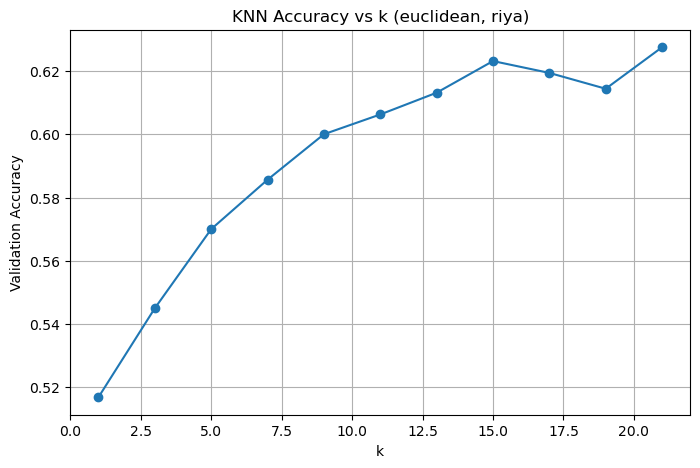

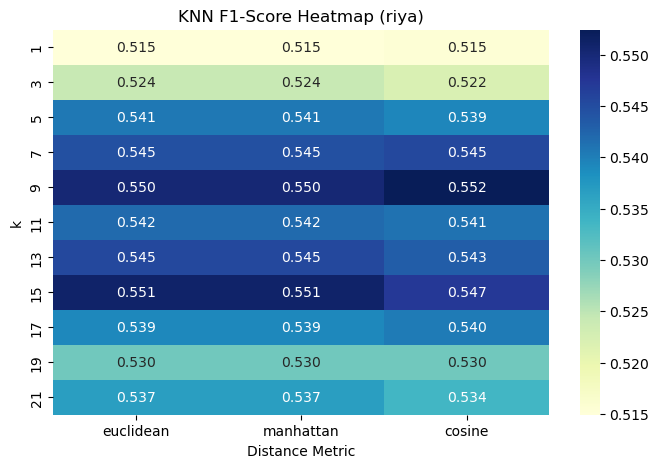

         GPA     major   program
1   0.515979   0.27747  0.541367
3   0.538685  0.430254  0.535922
5   0.541782  0.430254  0.535922
7   0.539619  0.365529  0.535922
9   0.531473  0.365529  0.535922
11  0.537327  0.532129  0.535922
13  0.529681  0.365529  0.418084
15  0.533704  0.365529  0.535922
17  0.526693  0.532129  0.535922
19  0.530104  0.532129  0.535922
21  0.532079  0.508961  0.535922


In [5]:
# 1️ Get dataset
dataset = StudentDataset(num_students=10000, seed=seed, username="riya")
full_df = dataset.get_full_dataframe()

# 2️ Initialize predictor
predictor = KNNGenderPredictor(student_df=full_df, username="riya")

# 3️ Train/val/test split
train, val, test = predictor.train_val_test_split(test_size=0.2, val_size=0.2, seed=seed)

# 4️ Define features and k values
features = ['GPA', 'major', 'program']
k_values = list(range(1, 22, 2))  # odd numbers 1-21
distances = ['euclidean', 'manhattan', 'cosine']

# 5️ Fit transformer and get transformed arrays
X_train, X_val, X_test, y_train, y_val, y_test = predictor.fit_transform_features(features)

# 6️ Accuracy vs k (Euclidean)
accuracies = predictor.get_knn_accuracy_vs_k(X_train, y_train, X_val, y_val, k_values, distance='euclidean')
predictor.plot_knn_accuracy_vs_k(k_values, accuracies, distance='euclidean')

# 7️ F1-score heatmap for all distances
f1_scores = predictor.get_knn_f1_heatmap(X_train, y_train, X_val, y_val, k_values, distances)
predictor.plot_knn_f1_heatmap(f1_scores)

# 8️ Single-feature F1-score table
single_feature_f1 = predictor.get_knn_f1_single_feature_table(features, k_values, distance='euclidean')
print(single_feature_f1)
